In [ ]:
#@title Sentiment Analysis of Twitter Data using VADER


In [1]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
#@title Data Exploration


In [2]:
from google.colab import files 
uploaded = files.upload()
import io 
tweets_text = pd.read_csv(io.BytesIO(uploaded['election_day_tweets.csv'])) 

Saving election_day_tweets.csv to election_day_tweets.csv


In [75]:
#Shape of the Tweet Dataset
print("Shape of the Tweet Dataset=",tweets_text.shape)

Shape of the Tweet Dataset= (397629, 34)


In [76]:
#Twitter Data Display
tweets_text.head()

,text,created_at,geo,lang,place,coordinates,user.favourites_count,user.statuses_count,user.description,user.location,user.id,user.created_at,user.verified,user.following,user.url,user.listed_count,user.followers_count,user.default_profile_image,user.utc_offset,user.friends_count,user.default_profile,user.name,user.lang,user.screen_name,user.geo_enabled,user.profile_background_color,user.profile_image_url,user.time_zone,id,favorite_count,retweeted,source,favorited,retweet_count
0,.@Lawrence @HillaryClinton Two first @SenSchu...,2016-11-08 04:04:37,NaN,en,NaN,NaN,18882,26939,"The Specialist, Copyrighted TX0008044160 #Surv...",WorldWide 80Million StealthRUs,22729901,2009-03-04 03:55:45,False,False,https://t.co/rKXNF1G270,374,86551,False,-28800.0,2674,False,Phillip Sheppard,en,PSheppardTV,True,131516,http://pbs.twimg.com/profile_images/7878871945...,America/Los_Angeles,795839414735732737,11,False,Twitter for Android,False,8
1,My @latimesopinion op-ed on historic #Californ...,2016-11-08 04:08:10,NaN,en,NaN,NaN,8,4841,Hoover Institution research fellow; https://t....,"Palo Alto, California",794779346,2012-08-31 22:13:27,False,False,https://t.co/K2fl294qFp,91,1689,False,-28800.0,344,False,Bill Whalen,en,hooverwhalen,True,C0DEED,http://pbs.twimg.com/profile_images/6514470051...,Pacific Time (US & Canada),795840310597193728,3,False,Twitter Web Client,False,4
2,#Senate Wisconsin Senate Preview: Johnson vs. ...,2016-11-08 04:11:35,NaN,en,NaN,NaN,728,160390,US SENATE NEWS FEED. The U.S. Senate is the w...,USA,190890578,2010-09-15 02:41:11,False,False,NaN,798,14726,False,-32400.0,13974,False,Quorum Call,en,QuorumCall,False,473969,http://pbs.twimg.com/profile_images/6155877017...,Alaska,795841168621719552,0,False,dlvr.it,False,0
3,If Rubio Wins and #Trump Loses in #Florida... ...,2016-11-08 04:12:16,NaN,en,NaN,NaN,0,18105,The most trending Marco Rubio news as collecte...,Washington DC,3175968009,2015-04-17 09:59:55,False,False,http://t.co/TbC8SzlTVN,57,121,False,NaN,96,True,Marco Rubio Trends,nl,Rubiolizer,False,C0DEED,http://pbs.twimg.com/profile_images/5890065307...,NaN,795841341146234880,0,False,Lead Stories Feed Publisher,False,0
4,#Senate Wisconsin Senate Preview: Johnson vs. ...,2016-11-08 04:16:20,NaN,en,NaN,NaN,4722,247322,News & #ALERTS. We are a large group of proud ...,24hr Live HD Stream Broadcast,2836839353,2014-10-19 04:50:02,False,False,https://t.co/ceRinWzb9I,288,17479,False,-18000.0,2291,False,NTA✪NEWS ROOM™,en,NoThiefs,False,1B95E0,http://pbs.twimg.com/profile_images/7971276617...,Eastern Time (US & Canada),795842365881782272,0,False,IFTTT,False,0


In [77]:
#Moving only Twitter Text to a separate dataframe
df = pd.DataFrame(tweets_text,columns =['text'])
df.head()

,text
0,.@Lawrence @HillaryClinton Two first @SenSchu...
1,My @latimesopinion op-ed on historic #Californ...
2,#Senate Wisconsin Senate Preview: Johnson vs. ...
3,If Rubio Wins and #Trump Loses in #Florida... ...
4,#Senate Wisconsin Senate Preview: Johnson vs. ...


In [78]:
#Checking for Null Values one by one for all files
df.isnull().sum()

text    0
dtype: int64

In [79]:
#Dropping the Duplicate Values if Any
df.drop_duplicates(inplace= True)

In [80]:
#Shape of File After Dropping Duplicates
print(" Shape of File after dropping duplicates: ",df.shape)

 Shape of File after dropping duplicates:  (393764, 1)


In [81]:
#@title Data Preprocessing


In [82]:
#Importing Necessary Libraries for Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re,string
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [83]:
#Stopwords

In [84]:
#Downloading Stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
#Load English Stop Words
stopword = stopwords.words('english')
print("Stopwords:",stopword)

Stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so'

In [86]:
#Tweet Clean Function
def tweet_clean(twee):
    #Remove URL
    twee = re.sub(r'https?://\S+|www\.\S+', " ", twee)

    #Remove Punctuation
    twee= re.sub(r'[^\w\s\d]',' ',twee)

    #Remove Digits
    twee = re.sub(r'\d+', ' ', twee)

    #Remove HTML tags
    twee = re.sub('r<.*?>',' ', twee)

    #Remove Stop Words 
    twee = twee.split()
    
    twee = " ".join([word for word in twee if not word in stopword])
    twee1 = twee.lower()

    return twee1

In [87]:
#Applying Tweet Clean Function to Both Files
df['text'] = df['text'].astype(str).apply(lambda x: tweet_clean(x))

In [88]:
#Updated Sentiment Data
df

,text
0,lawrence hillaryclinton two first senschumer t...
1,my latimesopinion op ed historic california se...
2,senate wisconsin senate preview johnson vs fei...
3,if rubio wins trump loses florida hillaryclint...
4,senate wisconsin senate preview johnson vs fei...
...,...
397624,today got stressed election
397625,my views election tune queceracera electionday...
397626,la disinvolta trasformazione da blog cazzi amp...
397627,one favorite shots take casting ballot nostalg...


In [125]:
#Adding Labels to the Dataset
Hillary_Keywords = ['hillary', 'clinton','hillaryclinton', 'democrats','voteblue', 'Democratic', 'kaine', 'tim','timkaine','billclinton','schumer','pelosi' ]
Trump_Keywords = ['trump', 'donald','donaldtrump','republicans','votered', 'americafirst', 'pence', 'mike','mikepence','melaniatrump', 'russia', 'mitch']
  
def assign_label(i):
  Dem = any(ele in i for ele in Hillary_Keywords)
  Rep = any(ele in i for ele in Trump_Keywords)
  if Dem == True:
    return 'Democrat'
  if Rep == True:
    return 'Republican'
  else:
    return 'Neutral'

In [126]:
#Adding Labels to the Dataset
df['Labels'] = df['text'].apply(assign_label)

In [127]:
#Label Distribution
df['Labels'].value_counts()

Neutral       282937
Democrat       59125
Republican     51702
Name: Labels, dtype: int64

In [128]:
#Labelled Dataset
df.head()

,text,Labels
0,lawrence hillaryclinton two first senschumer t...,Democrat
1,my latimesopinion op ed historic california se...,Democrat
2,senate wisconsin senate preview johnson vs fei...,Neutral
3,if rubio wins trump loses florida hillaryclint...,Democrat
4,senate wisconsin senate preview johnson vs fei...,Neutral


In [131]:
#Forming two dataframes based on Labels
df_dem = df[df['Labels'] == 'Democrat']
df_rep = df[df['Labels'] == 'Republican']

In [136]:
#Dataframe representing the Democrat label
df_dem1 = df_dem.reset_index(drop=True)
df_dem1

,text,Labels
0,lawrence hillaryclinton two first senschumer t...,Democrat
1,my latimesopinion op ed historic california se...,Democrat
2,if rubio wins trump loses florida hillaryclint...,Democrat
3,make republicans payaprice voteblue theballot ...,Democrat
4,ohio votehillary ohhillyes comeon voteblue the...,Democrat
...,...,...
59120,trump election eve if win single greatest wast...,Democrat
59121,hillaryforprison go vote trump election trump k,Democrat
59122,me polls today vote election america elections...,Democrat
59123,i gotta see whole thing cuz hillary went crazy,Democrat


In [137]:
#Dataframe representing the Republican label
df_rep1 = df_rep.reset_index(drop=True)
df_rep1

,text,Labels
0,she done america please vote realdonaldtrump m...,Republican
1,senate russia face immediate consequences mosc...,Republican
2,senate russia face immediate consequences mosc...,Republican
3,senate republicans acting though supreme court...,Republican
4,senate sessions stumps trump rises national st...,Republican
...,...,...
51697,zakaria trump cancer democracy voteyourfuture ...,Republican
51698,eyyyyy hilaryyy haddini bil başkan trump election,Republican
51699,go pennsylvania vote trumppence trump alwaystr...,Republican
51700,no offense trumpistas i hope donald loses toda...,Republican


In [141]:
#@title Sentiment Analysis


In [139]:
#Installing vaderSentiment
pip install vaderSentiment

     |████████████████████████████████| 133kB 5.6MB/s 


In [140]:
#Importing SentimentIntensityAnalyzer() that takes a string and returns a dictionary of scores in each of four categories
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [142]:
#Defining function for calculating the scores
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    #print("{:-<40} {}".format(sentence, str(score)))
    return score

In [143]:
#Scoring the texts for democrats
df_dem1['Sentiment_Polarity'] = df_dem1['text'].apply(sentiment_analyzer_scores)
df_dem1.head()

,text,Labels,Sentiment_Polarity
0,lawrence hillaryclinton two first senschumer t...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,my latimesopinion op ed historic california se...,Democrat,"{'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'comp..."
2,if rubio wins trump loses florida hillaryclint...,Democrat,"{'neg': 0.153, 'neu': 0.6, 'pos': 0.247, 'comp..."
3,make republicans payaprice voteblue theballot ...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,ohio votehillary ohhillyes comeon voteblue the...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [174]:
#Making a new column with the compound score
df_dem1['compound']  = df_dem1['Sentiment_Polarity'].apply(lambda score_dict: score_dict['compound'])
df_dem1

,text,Labels,Sentiment_Polarity,compound
0,lawrence hillaryclinton two first senschumer t...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,my latimesopinion op ed historic california se...,Democrat,"{'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'comp...",0.4939
2,if rubio wins trump loses florida hillaryclint...,Democrat,"{'neg': 0.153, 'neu': 0.6, 'pos': 0.247, 'comp...",0.3400
3,make republicans payaprice voteblue theballot ...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,ohio votehillary ohhillyes comeon voteblue the...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
...,...,...,...,...
59120,trump election eve if win single greatest wast...,Democrat,"{'neg': 0.128, 'neu': 0.411, 'pos': 0.461, 'co...",0.8074
59121,hillaryforprison go vote trump election trump k,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
59122,me polls today vote election america elections...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
59123,i gotta see whole thing cuz hillary went crazy,Democrat,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp...",-0.3400


In [179]:
#Assigninig sentiment labels positive, negative & neutral
def func(c):
  if c >= 0.05:
    return 'positive'
  elif c <= -0.05:
    return 'negative'
  else:
    return 'neutral'
    

df_dem1['Scores'] = df_dem1['compound'].apply(func)
df_dem1

,text,Labels,Sentiment_Polarity,compound,Scores
0,lawrence hillaryclinton two first senschumer t...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,my latimesopinion op ed historic california se...,Democrat,"{'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'comp...",0.4939,positive
2,if rubio wins trump loses florida hillaryclint...,Democrat,"{'neg': 0.153, 'neu': 0.6, 'pos': 0.247, 'comp...",0.3400,positive
3,make republicans payaprice voteblue theballot ...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
4,ohio votehillary ohhillyes comeon voteblue the...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
...,...,...,...,...,...
59120,trump election eve if win single greatest wast...,Democrat,"{'neg': 0.128, 'neu': 0.411, 'pos': 0.461, 'co...",0.8074,positive
59121,hillaryforprison go vote trump election trump k,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
59122,me polls today vote election america elections...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
59123,i gotta see whole thing cuz hillary went crazy,Democrat,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp...",-0.3400,negative


In [ ]:
#Scoring the texts for democrats
df_rep1['Sentiment_Polarity'] = df_rep1['text'].apply(sentiment_analyzer_scores)
df_rep1.head()

In [175]:
#Making a new column with the compound score
df_rep1['compound']  = df_rep1['Sentiment_Polarity'].apply(lambda score_dict: score_dict['compound'])
df_rep1

,text,Labels,Sentiment_Polarity,compound
0,she done america please vote realdonaldtrump m...,Republican,"{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp...",0.3182
1,senate russia face immediate consequences mosc...,Republican,"{'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'comp...",-0.1027
2,senate russia face immediate consequences mosc...,Republican,"{'neg': 0.097, 'neu': 0.903, 'pos': 0.0, 'comp...",-0.1027
3,senate republicans acting though supreme court...,Republican,"{'neg': 0.0, 'neu': 0.559, 'pos': 0.441, 'comp...",0.7430
4,senate sessions stumps trump rises national st...,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
...,...,...,...,...
51697,zakaria trump cancer democracy voteyourfuture ...,Republican,"{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'comp...",-0.6597
51698,eyyyyy hilaryyy haddini bil başkan trump election,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
51699,go pennsylvania vote trumppence trump alwaystr...,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
51700,no offense trumpistas i hope donald loses toda...,Republican,"{'neg': 0.11, 'neu': 0.669, 'pos': 0.222, 'com...",0.3270


In [180]:
#Assigninig sentiment labels positive, negative & neutral
df_rep1['Scores'] = df_rep1['compound'].apply(func)
df_rep1

,text,Labels,Sentiment_Polarity,compound,Scores
0,she done america please vote realdonaldtrump m...,Republican,"{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp...",0.3182,positive
1,senate russia face immediate consequences mosc...,Republican,"{'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'comp...",-0.1027,negative
2,senate russia face immediate consequences mosc...,Republican,"{'neg': 0.097, 'neu': 0.903, 'pos': 0.0, 'comp...",-0.1027,negative
3,senate republicans acting though supreme court...,Republican,"{'neg': 0.0, 'neu': 0.559, 'pos': 0.441, 'comp...",0.7430,positive
4,senate sessions stumps trump rises national st...,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
...,...,...,...,...,...
51697,zakaria trump cancer democracy voteyourfuture ...,Republican,"{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'comp...",-0.6597,negative
51698,eyyyyy hilaryyy haddini bil başkan trump election,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
51699,go pennsylvania vote trumppence trump alwaystr...,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
51700,no offense trumpistas i hope donald loses toda...,Republican,"{'neg': 0.11, 'neu': 0.669, 'pos': 0.222, 'com...",0.3270,positive


In [ ]:
#@title Visualizations


In [182]:
new = df_dem1.groupby('Scores').count()
x = list(new['compound'])
y = list(new.index)
tuple_list = list(zip(x,y))

df = pd.DataFrame(tuple_list, columns=['x','y'])

df['color'] = 'red'
df['color'][1] = 'grey'
df['color'][2] = 'green'

import plotly.graph_objects as go
fig = go.Figure(go.Bar(x=df['x'],
                y=df['y'],
                orientation ='h',
                marker={'color': df['color']}))
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [183]:
new = df_rep1.groupby('Scores').count()
x = list(new['compound'])
y = list(new.index)
tuple_list = list(zip(x,y))

df = pd.DataFrame(tuple_list, columns=['x','y'])

df['color'] = 'red'
df['color'][1] = 'grey'
df['color'][2] = 'green'

import plotly.graph_objects as go
fig = go.Figure(go.Bar(x=df['x'],
                y=df['y'],
                orientation ='h',
                marker={'color': df['color']}))
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [184]:
df_dem1.shape, df_rep1.shape

((59125, 5), (51702, 5))

In [192]:
#Types of Scores 
df_dem1['Scores'].value_counts()

neutral     25500
positive    21368
negative    12257
Name: Scores, dtype: int64

In [193]:
#Types of Scores 
df_rep1['Scores'].value_counts()

positive    20388
neutral     18866
negative    12448
Name: Scores, dtype: int64

In [195]:
#Removing rows with "Neutral" score
Dem_Neutral = df_dem1[df_dem1['Scores'] == 'neutral']
cond=df_dem1['Scores'].isin(Dem_Neutral['Scores'])
df_dem1.drop(df_dem1[cond].index, inplace = True)
df_dem1.shape

(33625, 5)

In [196]:
#Removing rows with "Neutral" score
Rep_Neutral = df_rep1[df_rep1['Scores'] == 'neutral']
cond=df_rep1['Scores'].isin(Rep_Neutral['Scores'])
df_rep1.drop(df_rep1[cond].index, inplace = True)
df_rep1.shape

(32836, 5)

In [214]:
#Creating list of positive & negative scores
count = (df_dem1['Scores'] == 'positive').value_counts()
count

True     21368
False    12257
Name: Scores, dtype: int64

In [215]:
Pos_dem = count[1]
Neg_dem = count[0]
Pos_dem, Neg_dem

(21368, 12257)

In [216]:
#Creating list of positive & negative scores
count = (df_rep1['Scores'] == 'positive').value_counts()
count

True     20388
False    12448
Name: Scores, dtype: int64

In [217]:
Pos_rep = count[1]
Neg_rep = count[0]
Pos_rep, Neg_rep

(20388, 12448)

In [218]:
#Visualization showing Positive-Negative tweets for both Democrats & Republicans
Parties = ['Democrats', 'Republicans']
pos = [Pos_dem, Pos_rep]
neg = [Neg_dem, Neg_rep]

fig = go.Figure(data=[
    go.Bar(name='Positive', x=Parties, y=pos),
    go.Bar(name='Negative', x=Parties, y=neg)
])
fig.update_layout(barmode='group')
fig.show()

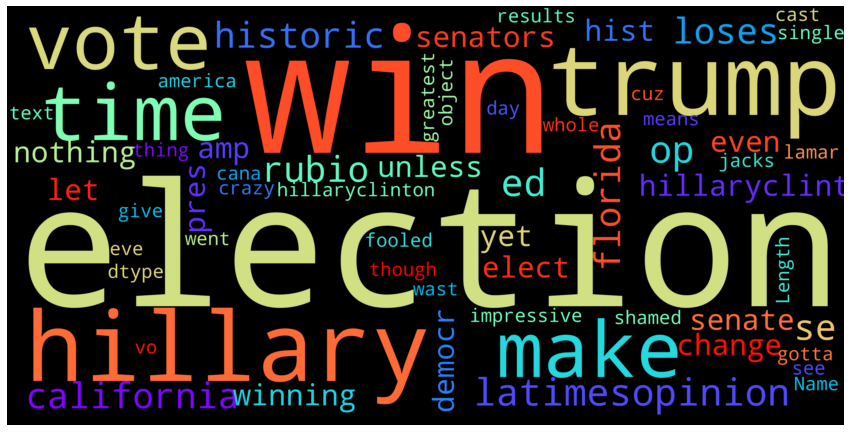

In [220]:
#Visualization showing the words associated with the tweets for Democrats 
from wordcloud import WordCloud
text = str(df_dem1.text)
wordcloud = WordCloud(max_font_size=100, max_words=500, scale=10, relative_scaling=.6, background_color="black", colormap = "rainbow").generate(text)

# Display the generated image:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

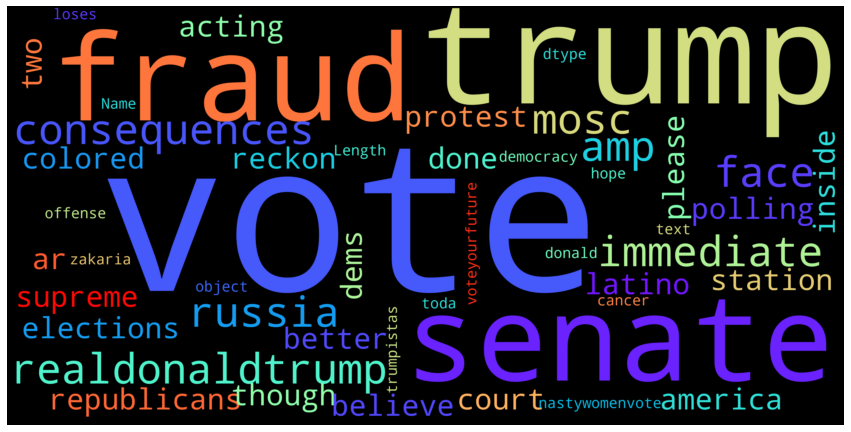

In [222]:
#Visualization showing the words associated with the tweets for Republicans 
text = str(df_rep1.text)
wordcloud = WordCloud(max_font_size=100, max_words=500, scale=10, relative_scaling=.6, background_color="black", colormap = "rainbow").generate(text)

# Display the generated image:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

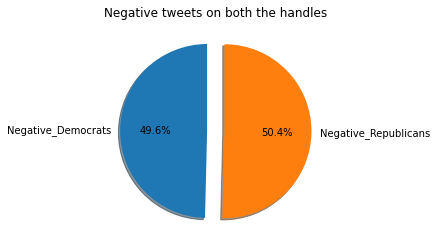

In [223]:
#Visualization showing the ratio of negative tweets for both Democrats & Republicans 
labels =  ['Negative_Democrats', 'Negative_Republicans'] 
sizes = neg
explode = (0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels = labels, autopct = '%1.1f%%', shadow = True, startangle=90)
ax1.set_title('Negative tweets on both the handles')
plt.show()

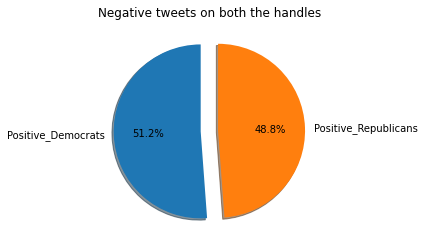

In [224]:
#Visualization showing the ratio of positive tweets for both Democrats & Republicans 
labels =  ['Positive_Democrats', 'Positive_Republicans'] 
sizes = pos
explode = (0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels = labels, autopct = '%1.1f%%', shadow = True, startangle=90)
ax1.set_title('Negative tweets on both the handles')
plt.show()